In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 1. Dataset
Génération de données aléatoires avec une tendance non linéaire avec make_circles : on a un dataset (x, y) qui contient 100 exemples, et deux variables x1.et x2

Note: chaque fois que la cellule est executée, des données différentes sont générer donc on affecte à l'argument random_state la valeur 0 pour reproduire le meme Dataset à chaque fois.

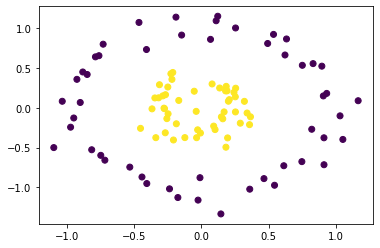

In [59]:
x,y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)

plt.scatter(x[:,0], x[:,1], c=y) # afficher les résultats. X[:,0] en abscisse et X[:,1] en ordonnée

Pour effectuer un calcul matriciel correct, il est important de vérifier les dimensions de X et Y. On remarque que y n'a pas les dimensions (100, 1). On corrige le probleme avec np.reshape

In [60]:
print('Les dimensions de X : ',x.shape)
print('Les dimensions de Y : ',y.shape)

# redimensionner y
y = y.reshape(y.shape[0], 1)

print('Les nouvelles dimensions de Y : ',y.shape)

Les dimensions de X :  (100, 2)
Les dimensions de Y :  (100,)
Les nouvelles dimensions de Y :  (100, 1)


#### Division de X et Y en sous ensemble train et test

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

print(x_train.shape)
print(x_test.shape)

(80, 2)
(20, 2)


In [62]:
# on transpose les matrices
X = x.T
Y = x.T
X_train = x_train.T
Y_train = y_train.T
X_test = x_test.T
Y_test = y_test.T

print('X : ',X.shape)
print('Y : ',Y.shape)
print('X_train : ',X_train.shape)
print('Y_train : ',Y_train.shape)
print('X_test : ',X_test.shape)
print('Y_test : ',Y_test.shape)

X :  (2, 100)
Y :  (2, 100)
X_train :  (2, 80)
Y_train :  (1, 80)
X_test :  (2, 20)
Y_test :  (1, 20)


# 2. Fonctions du modèle
### - Initialisation des parametres W et b de chaque couche

In [63]:
def initialisations(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

### - Modele
On implémente la fonction qui represente notre modele celle dans laquelle on va retrouver les fonctions lineaires $Z^{[c]} = W^{[c]}.A^{[c-1]} + b^{[c]}$ puis les fonctions d'activation sigmoïde (ou fonctions logistiques) $ A^{[c]} = \frac{1}{1 + e^{-Z^{[c]}}}  $ 

In [64]:
def forward_propagation(X, parametres):
    activations = {'A0': X}

    C = len(parametres) // 2

    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

### - Gradients et Descente de Gradient
On Calcul le gradient de la fonction cout grace aux formules suivantes : 

$dZ^{[C_f]}=A^{[C_f]}-y$

$dW^{[C]}= \frac {1}{m}*dZ^{[C]}.A^{[C-1]^{T}}$

$db^{[C]}=\frac {1}{m}*\sum {dZ^{[C]}}$


$dZ^{[C-1]}={W^{[C]}}^{T}.dZ^{[C]}*A^{[C-1]}.(1-A^{[C-1]})$

Puis nous utiliserons ces gradients dans la fonction descente de gradient qui permettra de mettre à jour les parametres W et b
pour minimiser les erreurs

$W^{[C]} = W^{[C]} - \alpha  dW^{[C]}$

$b^{[C]} = b^{[C]} - \alpha  dW^{[C]}$

In [65]:
def back_propagation(y, parametres, activations):
    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

In [66]:
def gradient_descent(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

### - Prédiction

In [67]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [109]:
def neural_network(X_train, Y_train, X_test, Y_test, hidden_layers = (16, 16, 16), learning_rate = 0.001, n_iterations = 3000):
    
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(Y_train.shape[0])
    np.random.seed(1)
    parametres = initialisations(dimensions)

    train_loss = []
    train_acc = []

    C = len(parametres) // 2

    # gradient descent
    for i in tqdm(range(n_iterations)):

        activations = forward_propagation(X_train, parametres)
        gradients = back_propagation(Y_train, parametres, activations)
        parametres = gradient_descent(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]
        
        # calcul du log_loss et de l'accuracy
        train_loss.append(log_loss(Y_train,activations['A'+str(C)]))
        y_pred = predict(X_test, parametres)
        train_acc.append(accuracy_score(Y_test.flatten(), y_pred.flatten()))
        
    # Visualisation des résultats
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 4))
    ax[0].plot(train_loss, label="Train loss")
    ax[0].legend()
                         
    ax[1].plot(train_acc, label="Train acc")
    ax[1].legend()                    
    plt.show 
                         
    return train_acc

# Test

100%|██████████| 3000/3000 [00:05<00:00, 553.86it/s]


[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.75,
 0.8,
 0.85,
 0.85,
 0.8,
 0.8,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,


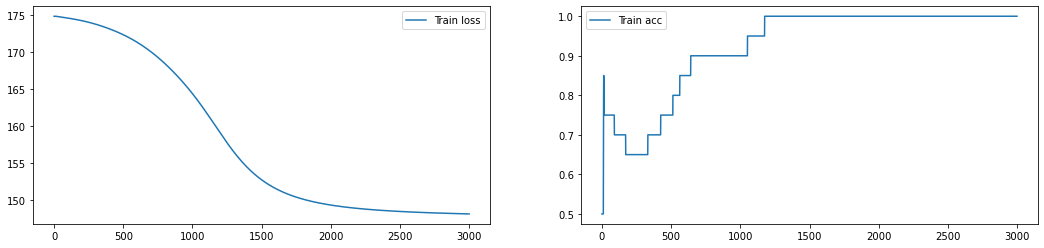

In [110]:
neural_network(X_train, Y_train, X_test, Y_test, hidden_layers = (16, 16, 16), learning_rate = 0.1)